In [1]:
# toc
import os

import matplotlib.pyplot as plt
import certifi
import numpy as np
import seaborn as sns
import cv2

from sklearn.metrics import confusion_matrix, accuracy_score

# noinspection PyUnresolvedReferences
from tensorflow.keras.datasets import cifar10
# noinspection PyUnresolvedReferences
from tensorflow.keras.models import Sequential, load_model
# noinspection PyUnresolvedReferences
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D
# noinspection PyUnresolvedReferences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# noinspection PyUnresolvedReferences
from tensorflow.keras.applications import MobileNetV2
# noinspection PyUnresolvedReferences
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# If you have a raw python installation, you have to set the SSL_CERT_FILE environment variable
os.environ['SSL_CERT_FILE'] = certifi.where()

plt.style.use('../maroon_ipynb.mplstyle')

# ignore all warnings
import tensorflow as tf
# noinspection PyUnresolvedReferences
tf.get_logger().setLevel('ERROR')

# Problem 1

Keras includes the CIFAR-10 dataset, a collection of 60,000 32x32 color images. Each contains 1 of 10 different objects, and the dataset is often used as a benchmark for classification schemes. The 10 different classes are: airplane, car, bird, cat, deer, dog, frog, horse, ship, and truck. In this assignment you will build a CNN to attempt to correctly classify these images.

Check the labels on the data to see how many of each class are present in the training and test datasets. Do you foresee any issues with this data balance? Plot a few of the images as well to get a sense for what the images look like to the human eye.

## Solution

In [2]:
# load the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# normalize the data
x_train = x_train/255
x_test = x_test/255

Upon inspection of the data, we see that `x_train` is a 50,000x32x32x3 array meaning we have 50,000 images of size 32x32 with 3 color channels. `y_train` is a 50,000x1 array of labels. `x_test` is a 10,000x32x32x3 array and `y_test` is a 10,000x1 array of labels. The target values are represented with integers from 0 to 9, corresponding to the class names below as the `class_names` list.

Let's show the first of each class that we see in the training data.

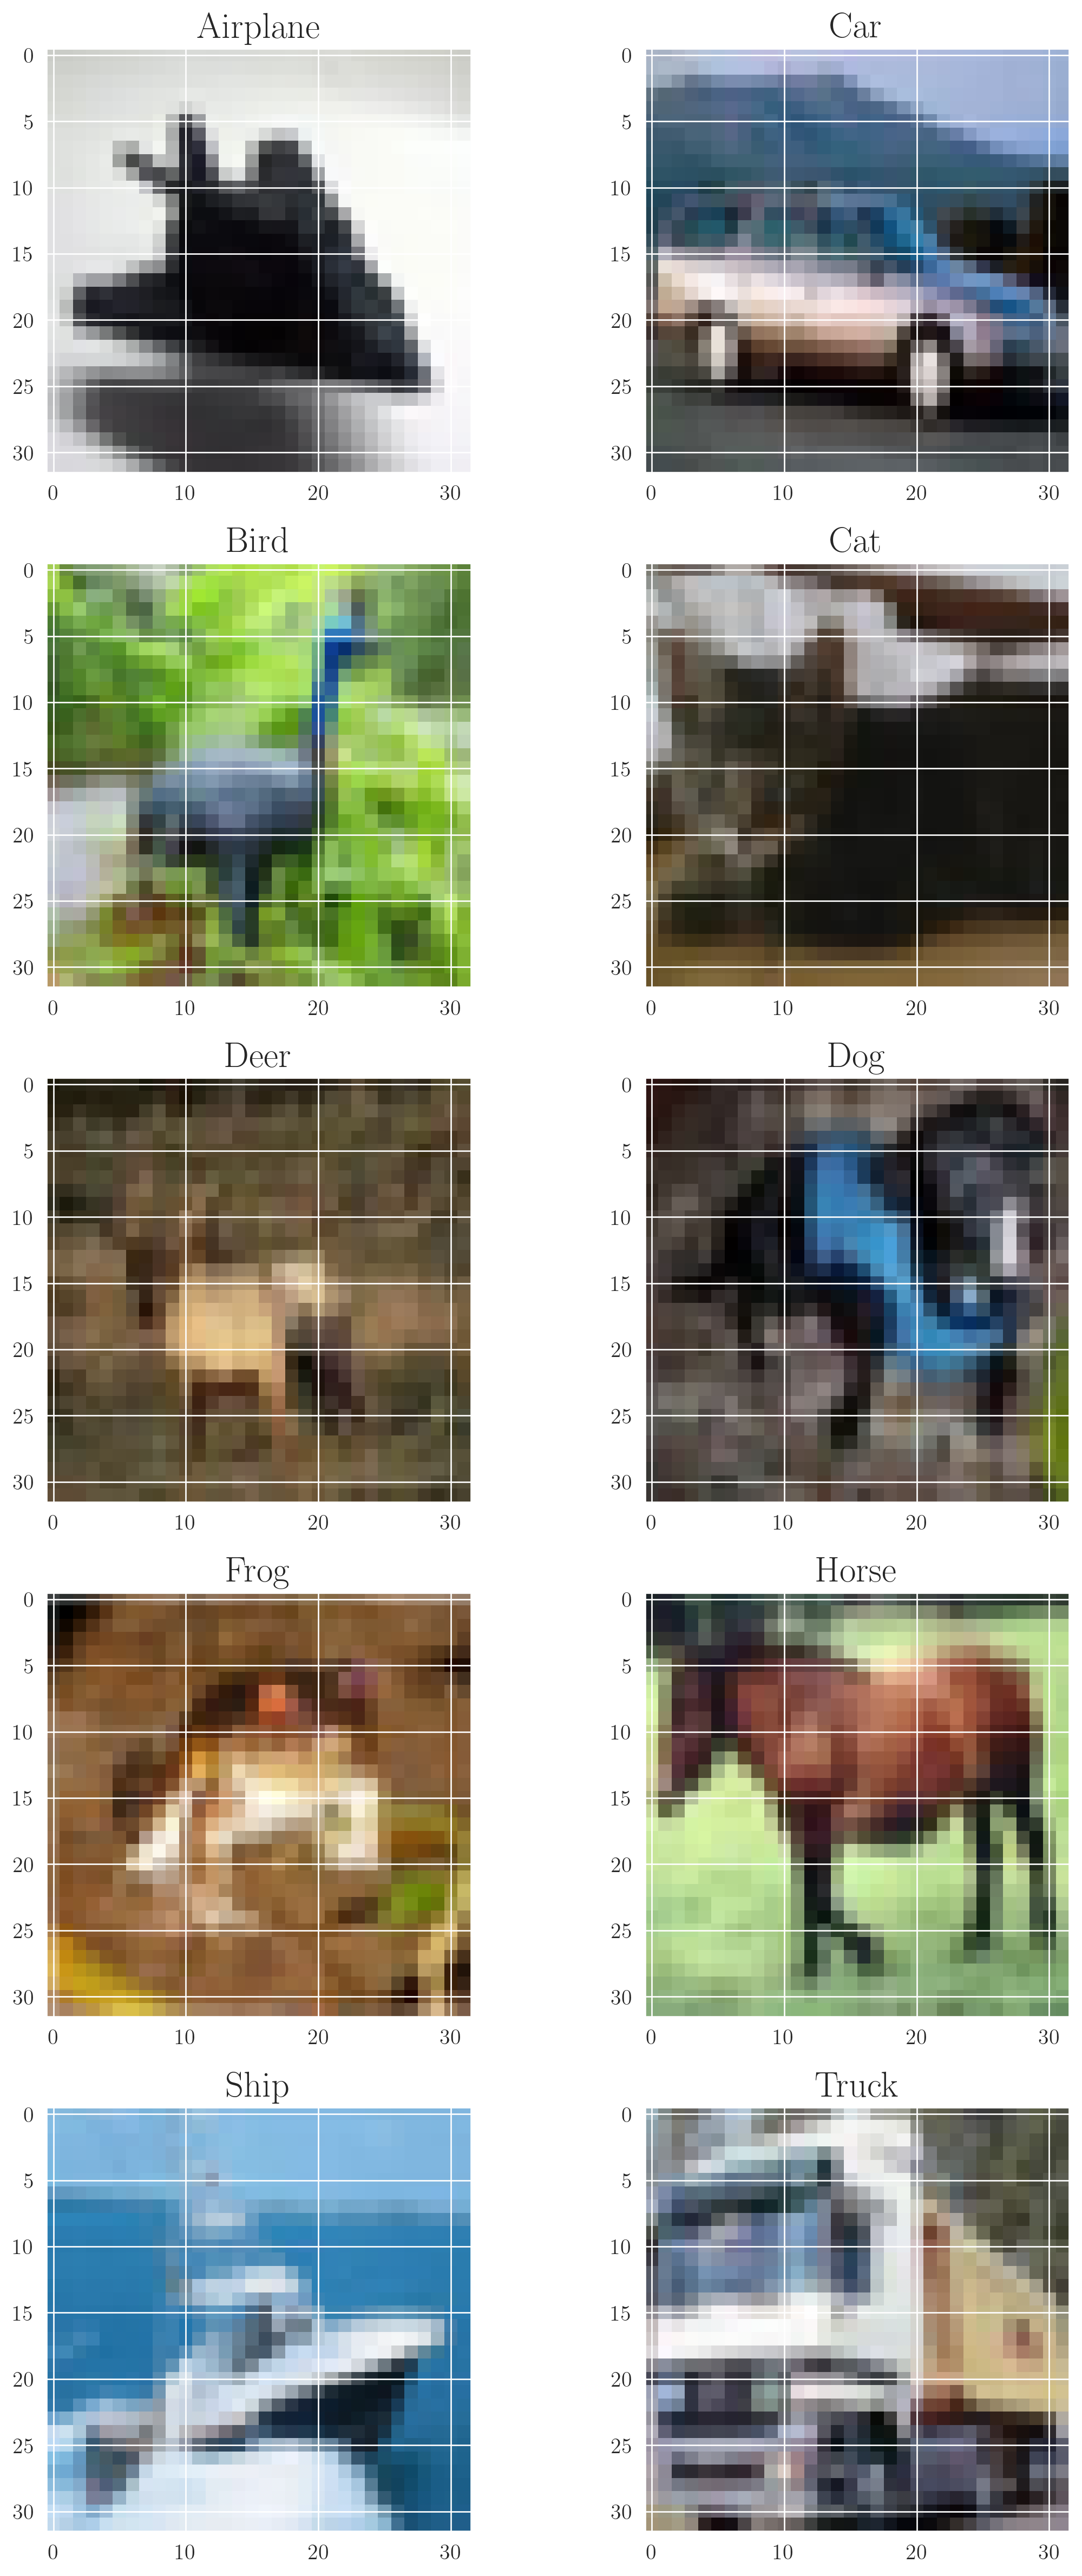

In [3]:
# Plotting the images
# class names order is seen in the doc strings of cifar10
class_names = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
classes_seen = set()

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
axes = ax.flatten()

i = 0
while len(classes_seen) < len(class_names):
    label = y_train[i][0]
    if label not in classes_seen:
        classes_seen.add(label)
        axes[label].imshow(x_train[i])
        axes[label].set_title(class_names[label])
    i += 1
plt.show()

In [4]:
# Finding the number of each class in the training and test data
train_counts = np.bincount(y_train.flatten())
test_counts = np.bincount(y_test.flatten())

# print the counts
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {train_counts[i]} training images, {test_counts[i]} test images')

Airplane: 5000 training images, 1000 test images
Car: 5000 training images, 1000 test images
Bird: 5000 training images, 1000 test images
Cat: 5000 training images, 1000 test images
Deer: 5000 training images, 1000 test images
Dog: 5000 training images, 1000 test images
Frog: 5000 training images, 1000 test images
Horse: 5000 training images, 1000 test images
Ship: 5000 training images, 1000 test images
Truck: 5000 training images, 1000 test images


The CIFAR-10 dataset is designed so that each of the 10 classes has the same number of images—specifically, 5000 training images and 1000 test images per class. This balance ensures that models trained on the dataset don’t become biased towards any one class and helps provide a fair evaluation during testing. So no, I don't foresee any issues with this data balance.

# Problem 2
Build a simple CNN with a single convolution layer and a single dense hidden layer and train it over the data. Plot the evolution of the accuracy and the loss as a function of epoch. Show a confusion matrix for the best result from the training.

## Solution

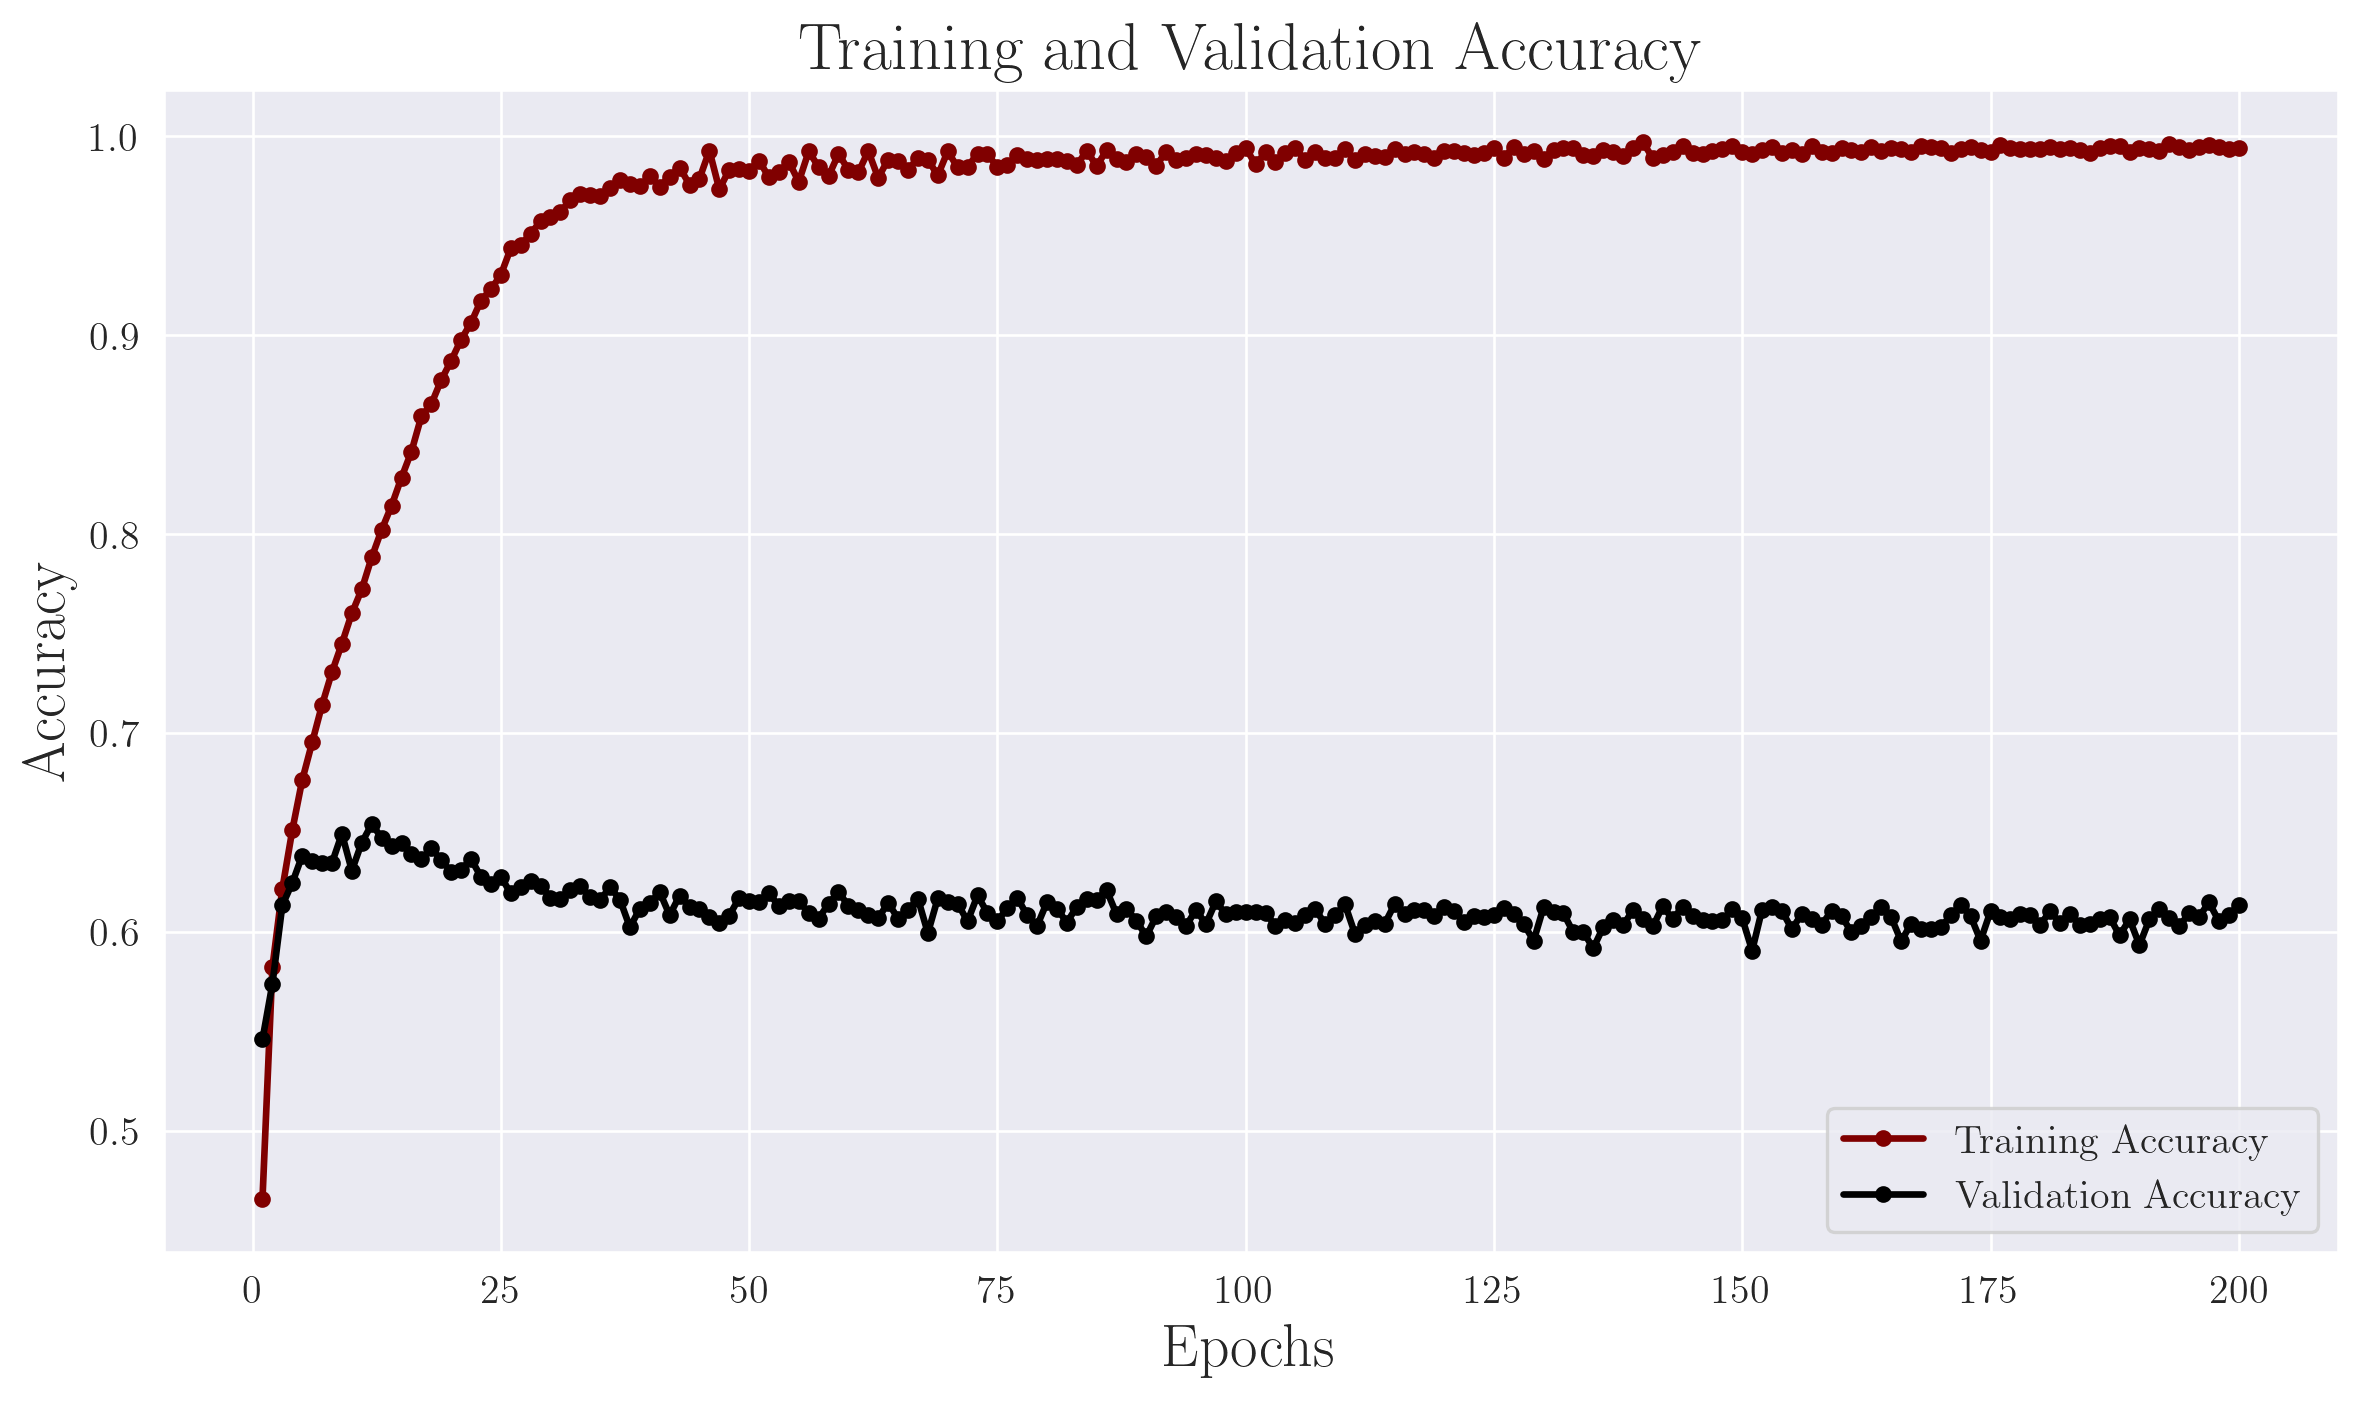

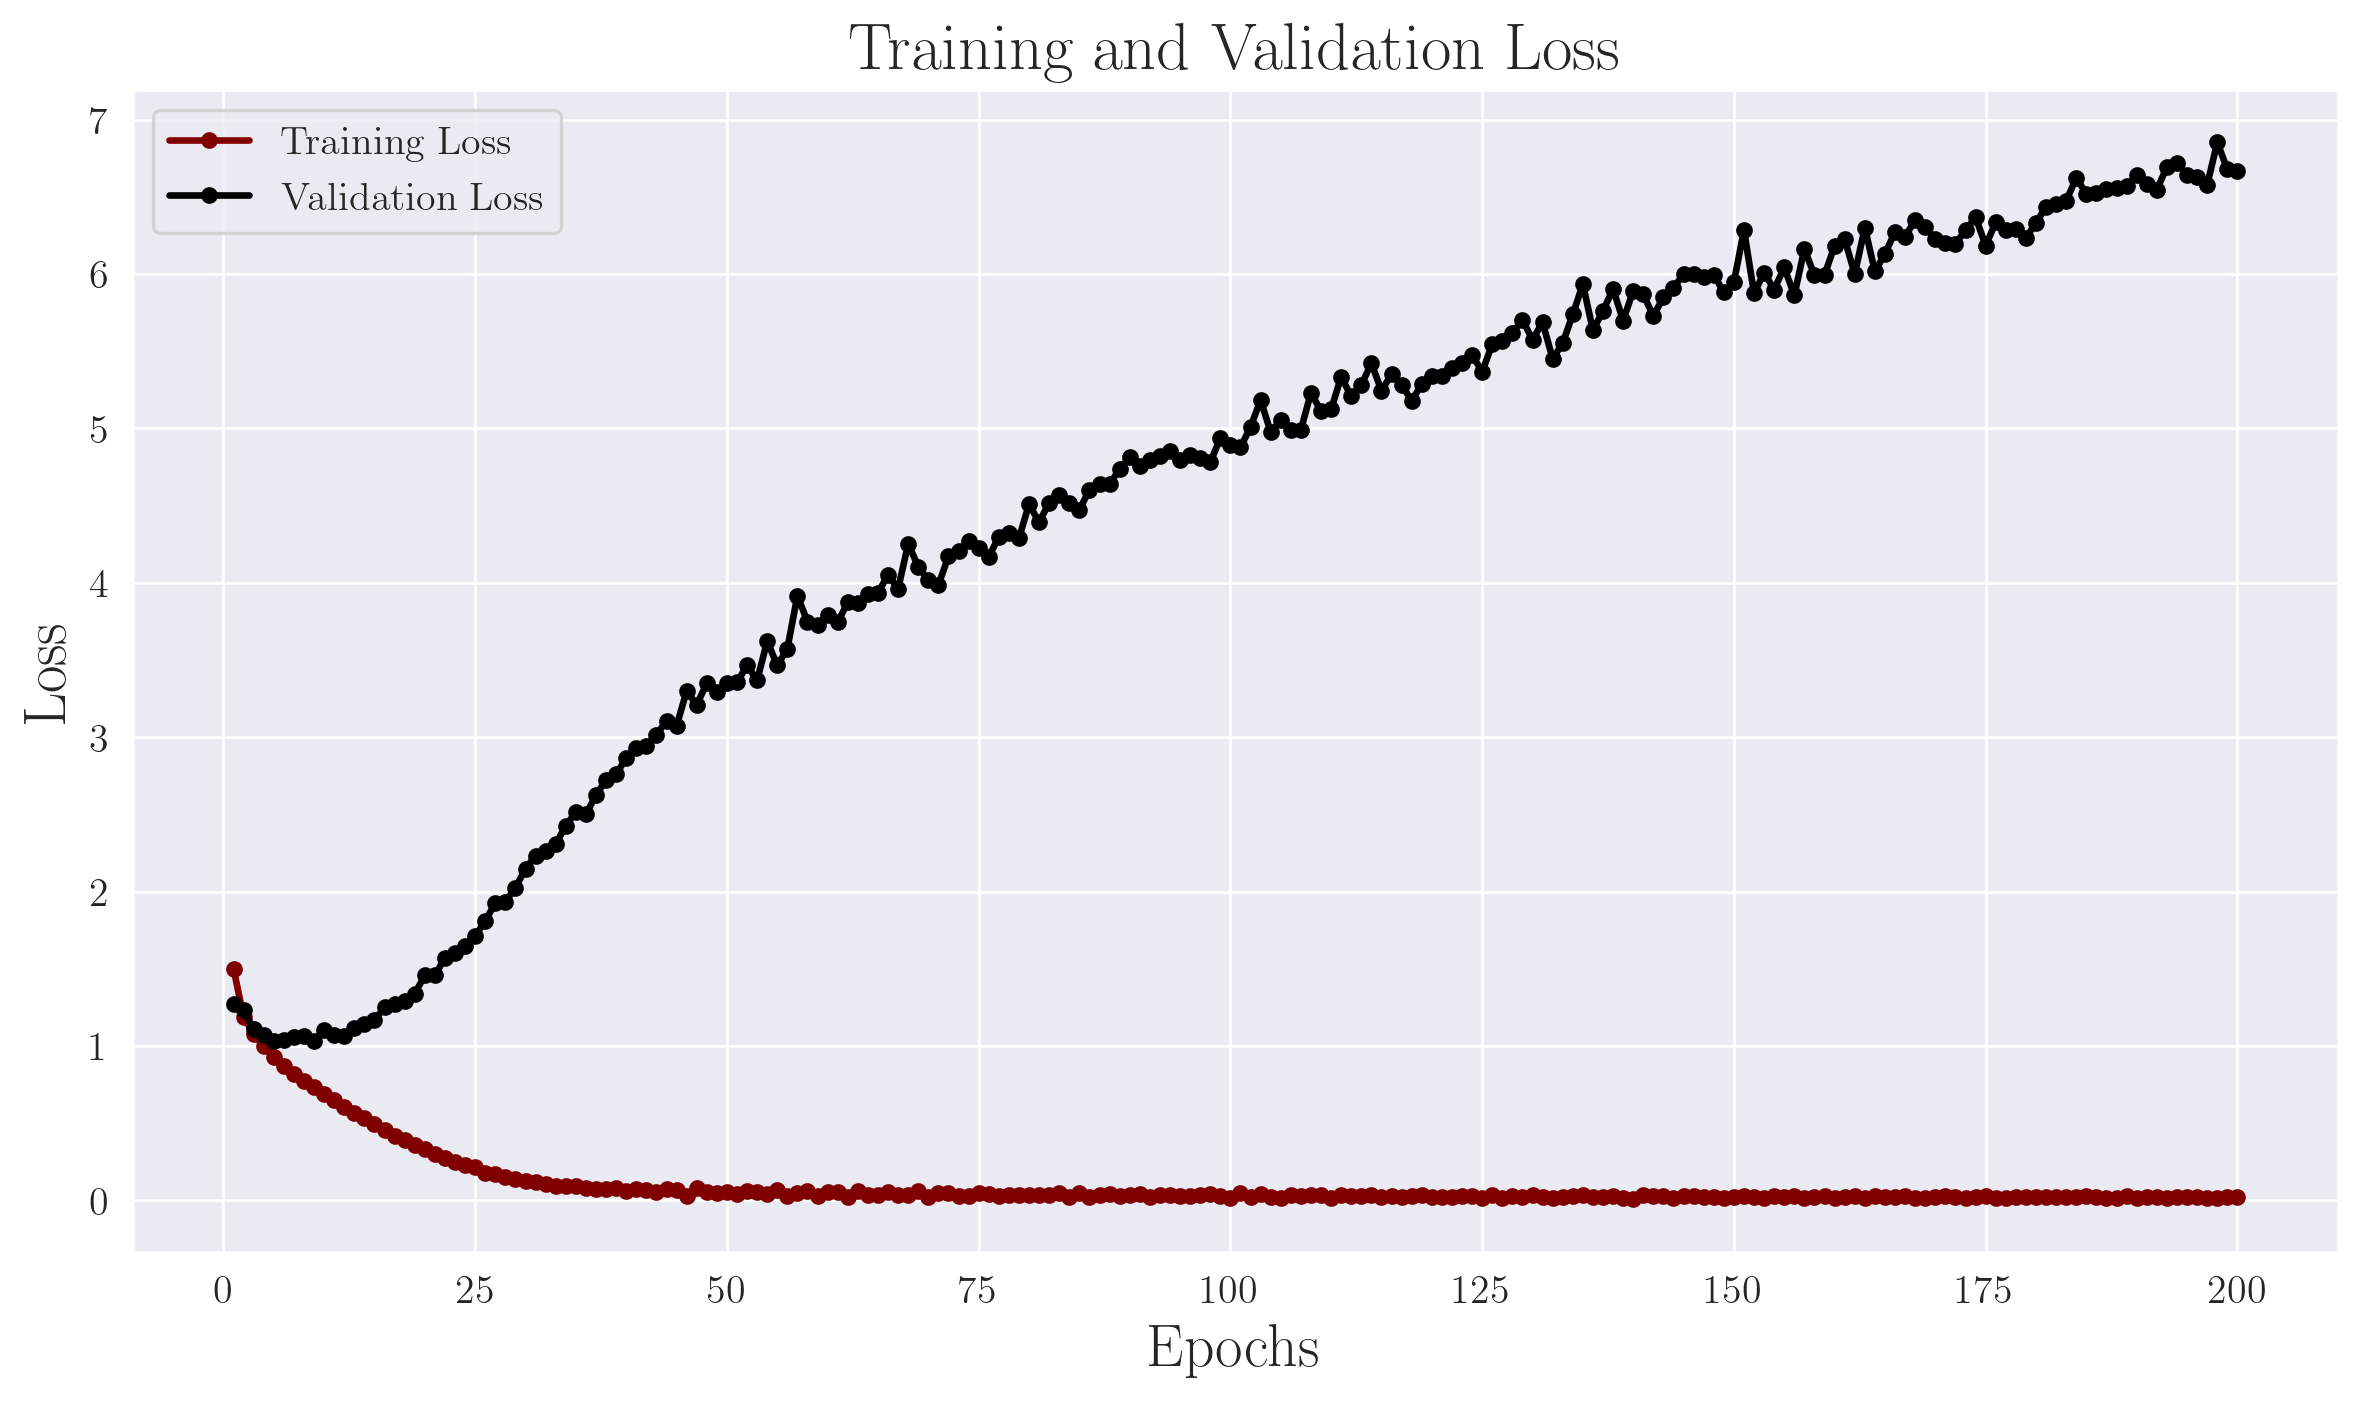

In [5]:
# Create model
p2_model = Sequential([
    Input(shape=(32, 32, 3)),  # input shape
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),  # convolution layer
    MaxPooling2D(pool_size=(2, 2)),  # max pooling layer
    Flatten(),  # flatten the output
    Dense(128, activation='relu'),  # dense hidden layer
    Dense(10, activation='softmax')  # output layer with softmax activation
])

# Compile model
p2_model.compile(
    optimizer='adam',  # optimizer
    loss='sparse_categorical_crossentropy',  # loss function for multi-class classification
    metrics=['accuracy']  # metric to track
)

# Define callback to save the best model based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    'best_model_p2.keras',  # file to save the model
    monitor='val_acc',  # monitor validation accuracy
    save_best_only=True,  # save only the best model
    mode='max',  # maximize the monitored metric
    verbose=False  # suppress output
)

# Train the model
history = p2_model.fit(
    x_train, y_train,  # training data
    epochs=200,  # number of epochs
    batch_size=64,  # batch size
    validation_data=(x_test, y_test),  # validation data
    callbacks=[checkpoint_callback],  # callback to save the best model
    verbose=False  # suppress output during training
)
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.array(history.epoch) + 1

# Plot the training and validation accuracy
fig, ax = plt.subplots()
ax.plot(epochs, train_accuracy, label='Training Accuracy', marker='.')
ax.plot(epochs, val_accuracy, label='Validation Accuracy', marker='.')
ax.set_title('Training and Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

# Plot the training and validation loss
fig, ax = plt.subplots()
ax.plot(epochs, train_loss, label='Training Loss', marker='.')
ax.plot(epochs, val_loss, label='Validation Loss', marker='.')
ax.set_title('Training and Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

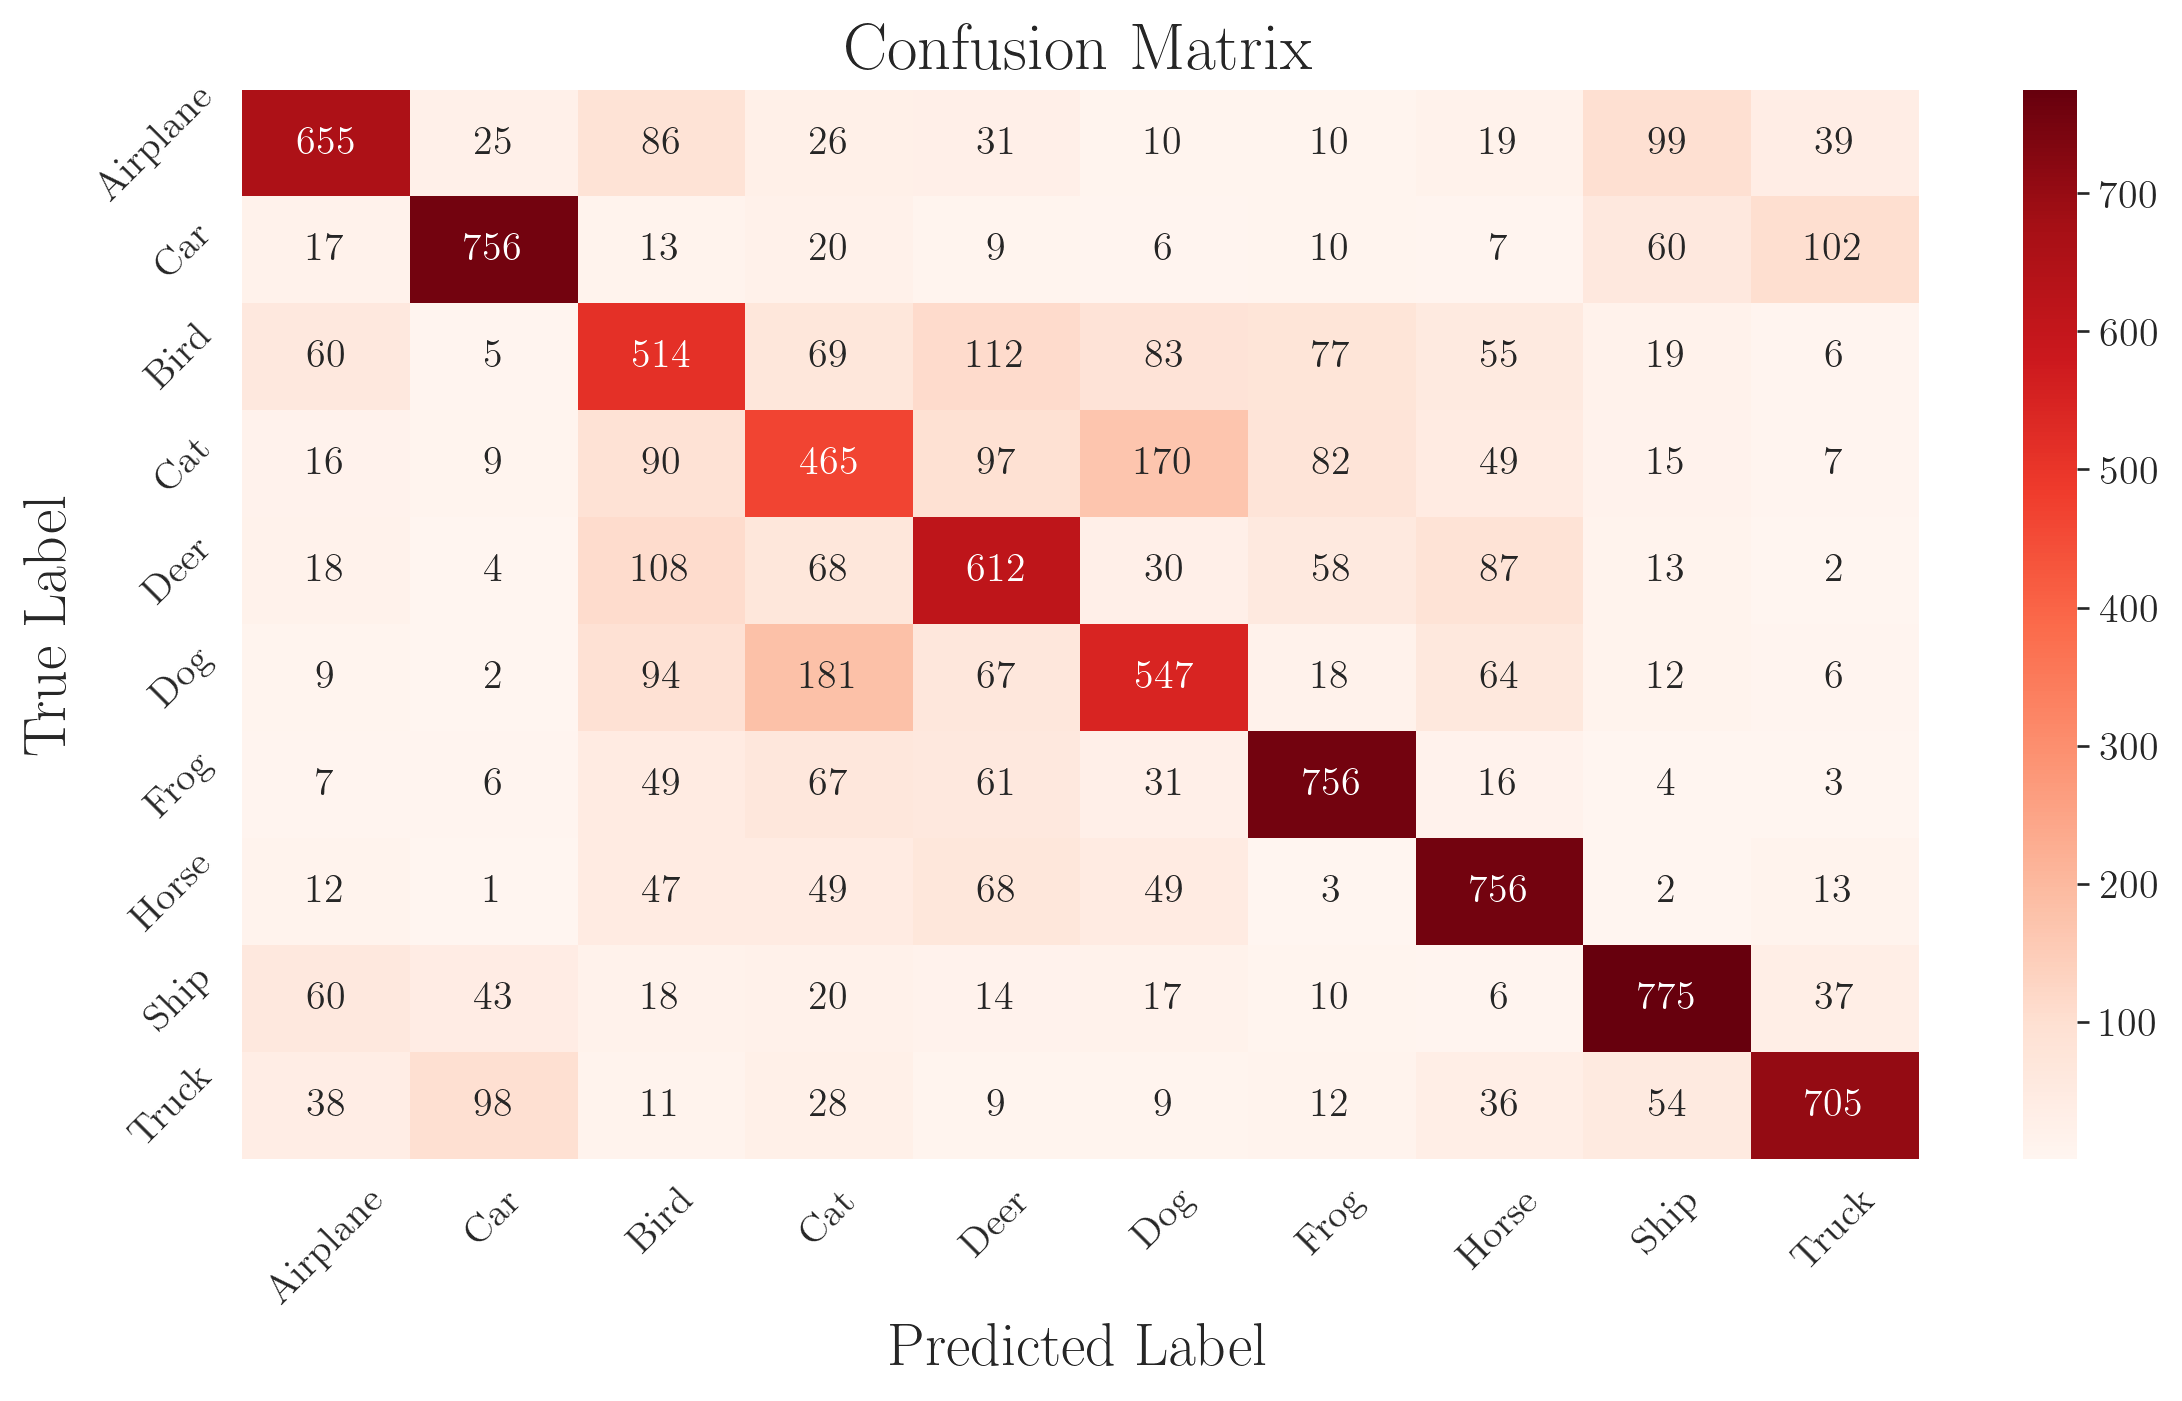

In [6]:
# Making the confusion matrix
p2_best_model = load_model('best_model_p2.keras')  # Load the best model
y_pred = p2_best_model.predict(x_test, verbose=False)  # Get predictions on the test set

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)  # finding the highest probability
cm = confusion_matrix(y_test.flatten(), y_pred_labels)

# Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=45)
plt.show()

In [7]:
# Accuracy score
accuracy = accuracy_score(y_test.flatten(), y_pred_labels)
print(f'Accuracy of the best model on the test set: {accuracy:.3%}')

Accuracy of the best model on the test set: 65.410%


These results show that overfitting typically occurs around epoch 10 for this simple model. The training accuracy continues to improve while the validation accuracy starts to decline. This is even more evident in the loss plots, where the training loss keeps decreasing while the validation loss increases after epoch 10. This is a result of the simple architecture quickly learning the training data but failing to generalize to unseen data.

# Problem 3
Measure how the accuracy varies as you change the size of the single convolution layer. Does there appear to be an ideal size for training?

## Solution
I am going to assume that this means we are changing the filter size of the convolution layer.

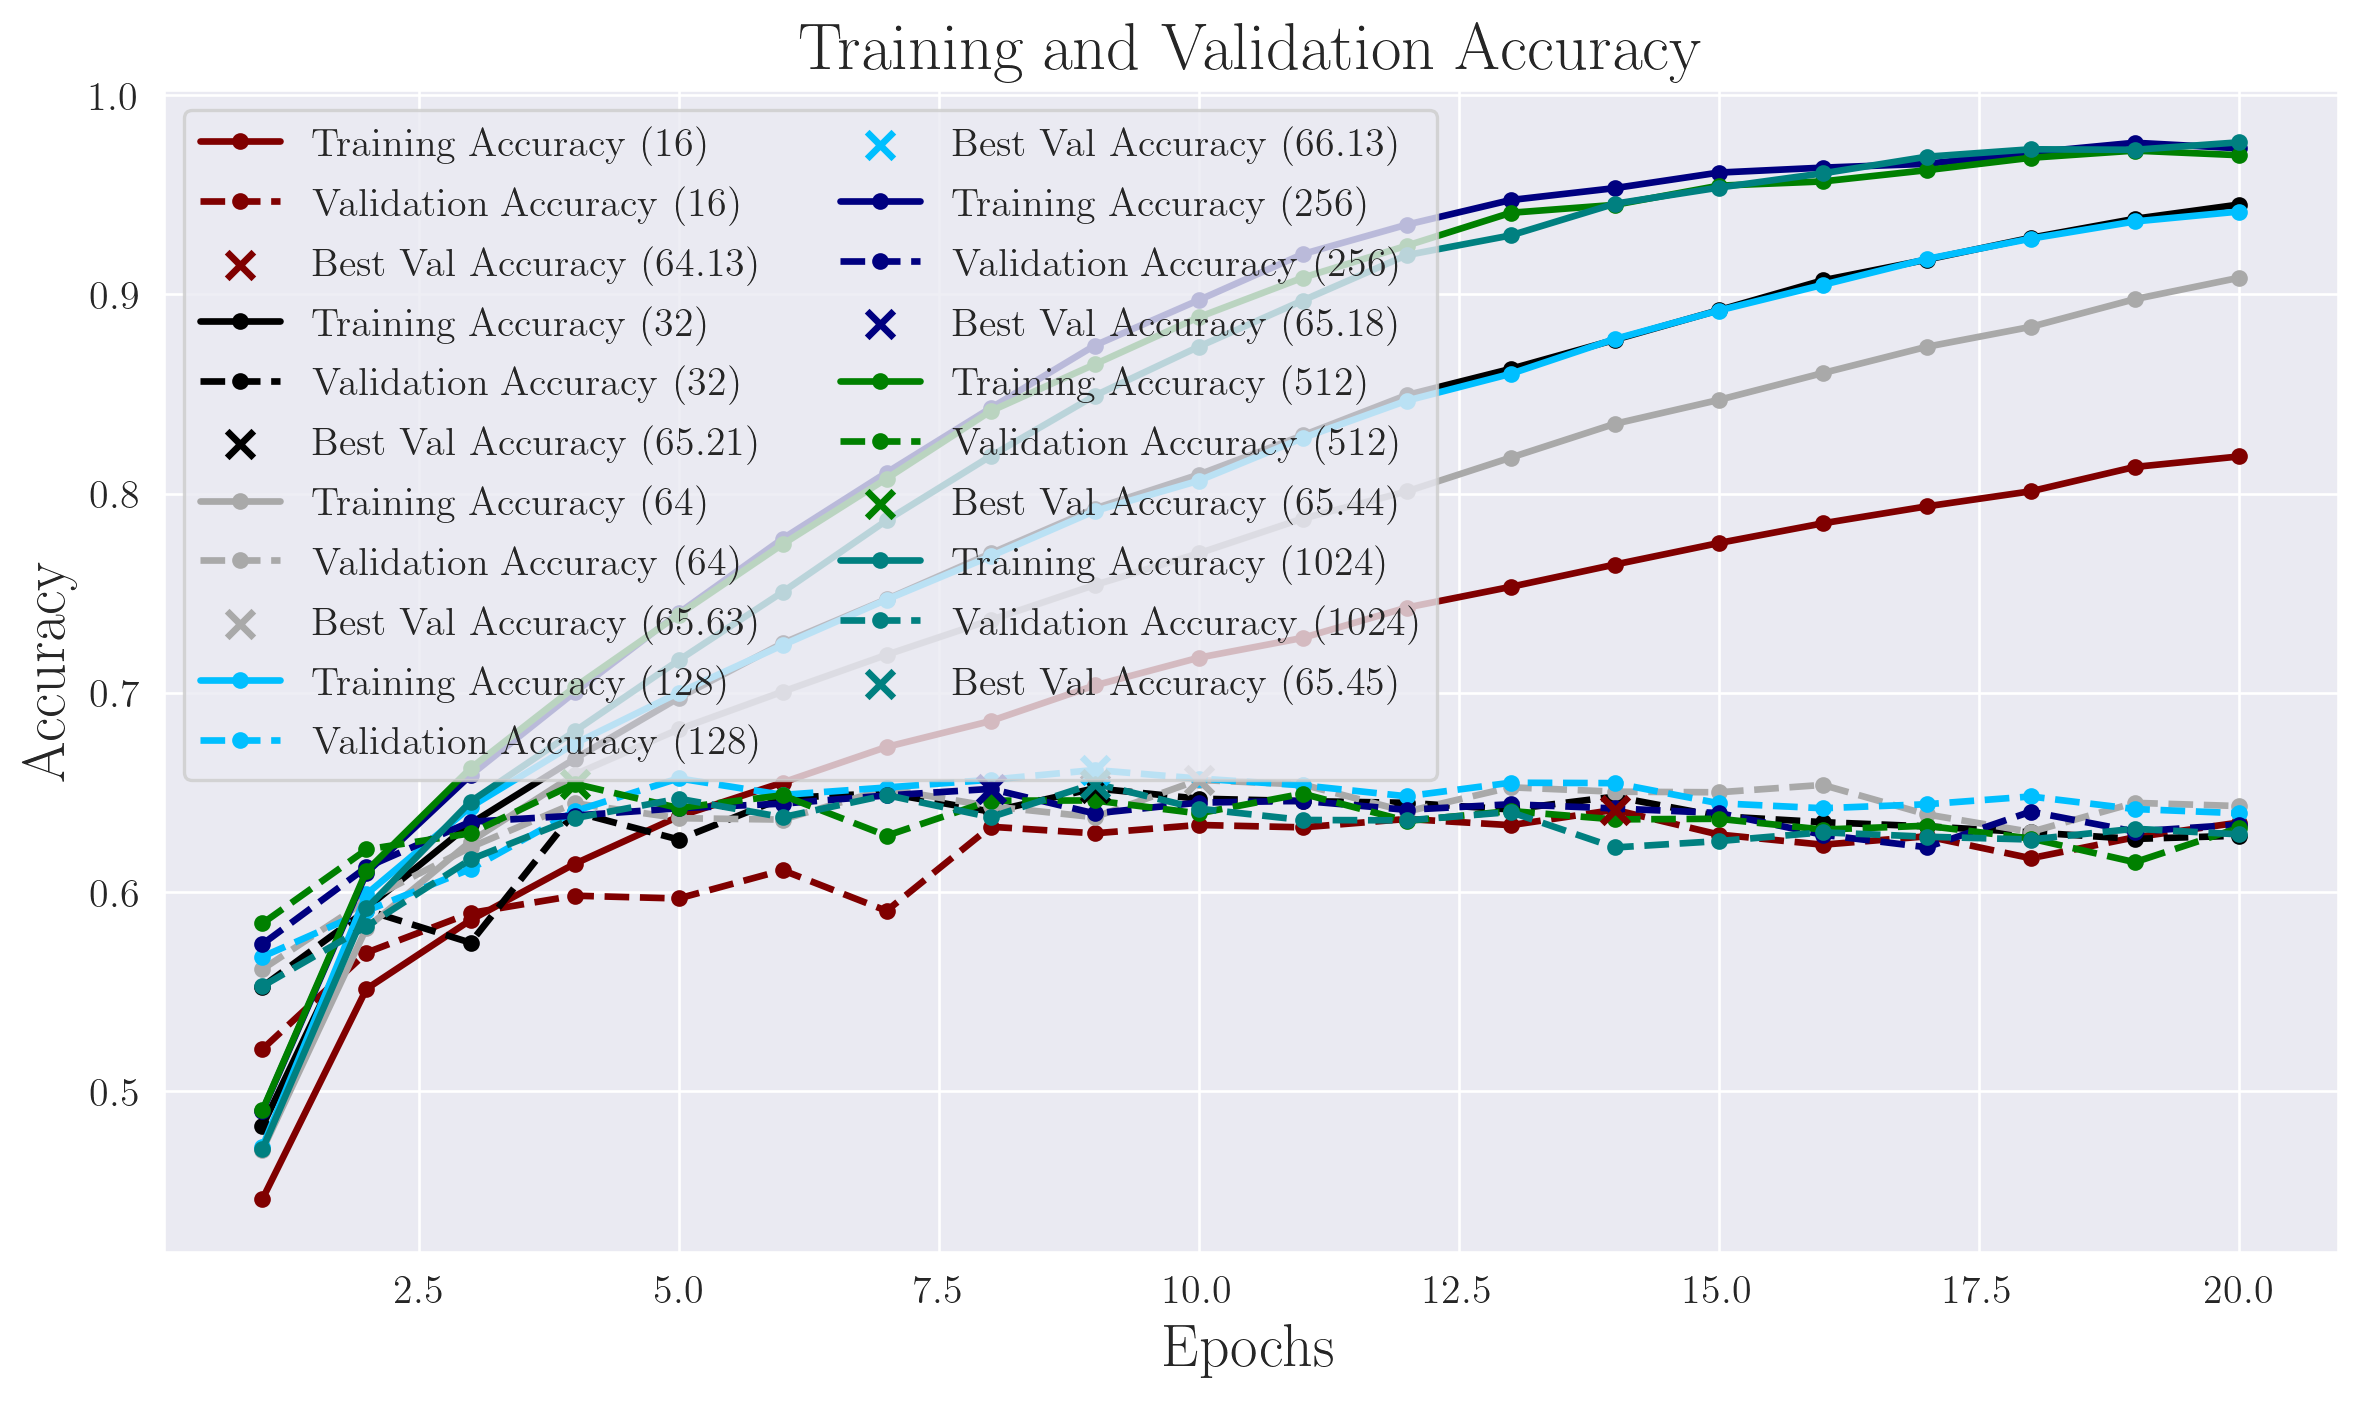

In [8]:
fig, ax = plt.subplots()
filter_sizes = [16, 32, 64, 128, 256, 512, 1024]
for filter_size in filter_sizes:
    # Create model
    p3_model = Sequential([
        Input(shape=(32, 32, 3)),  # input shape
        Conv2D(filters=filter_size, kernel_size=(3, 3), activation='relu'),  # convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # max pooling layer
        Flatten(),  # flatten the output
        Dense(128, activation='relu'),  # dense hidden layer
        Dense(10, activation='softmax')  # output layer with softmax activation
    ])

    # Compile model
    p3_model.compile(
        optimizer='adam',  # optimizer
        loss='sparse_categorical_crossentropy',  # loss function for multi-class classification
        metrics=['acc']  # metric to track
    )

    # Train the model
    history = p3_model.fit(
        x_train, y_train,  # training data
        epochs=20,  # number of epochs
        batch_size=64,  # batch size
        validation_data=(x_test, y_test),  # validation data
        verbose=False  # suppress output during training
    )
    train_accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    epochs = np.array(history.epoch) + 1
    best_accuracy = max(val_accuracy)  # find the best validation accuracy
    best_accuracy_epoch = val_accuracy.index(best_accuracy) + 1  # find the epoch at which it occurred

    # Plot the training and validation accuracy
    line = ax.plot(epochs, train_accuracy, label=f'Training Accuracy ({filter_size})', marker='.', zorder=2)[0]
    ax.plot(epochs, val_accuracy, label=f'Validation Accuracy ({filter_size})', marker='.', ls='--', color=line.get_color(), zorder=2)
    ax.scatter(best_accuracy_epoch, best_accuracy, marker='x', color=line.get_color(), zorder=3, label=fr'Best Val Accuracy ({best_accuracy*100:.2f})')

ax.set_title('Training and Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend(ncol=2)
plt.show()

The results show that as the output size of the convolution layer increases, the validation accuracy has little change. The training accuracy, however, will converge quicker as the filter size increases, which means that the validation accuracy converges in fewer epochs, but each epoch takes longer to train with the higher number of filters. Nevertheless, a filter size of 32 or 64 seems to be alright, but I don't see major differences that would warrant an ideal size.

# Problem 4
Now vary the size of the dense layer and do the same analysis as above.

## Solution

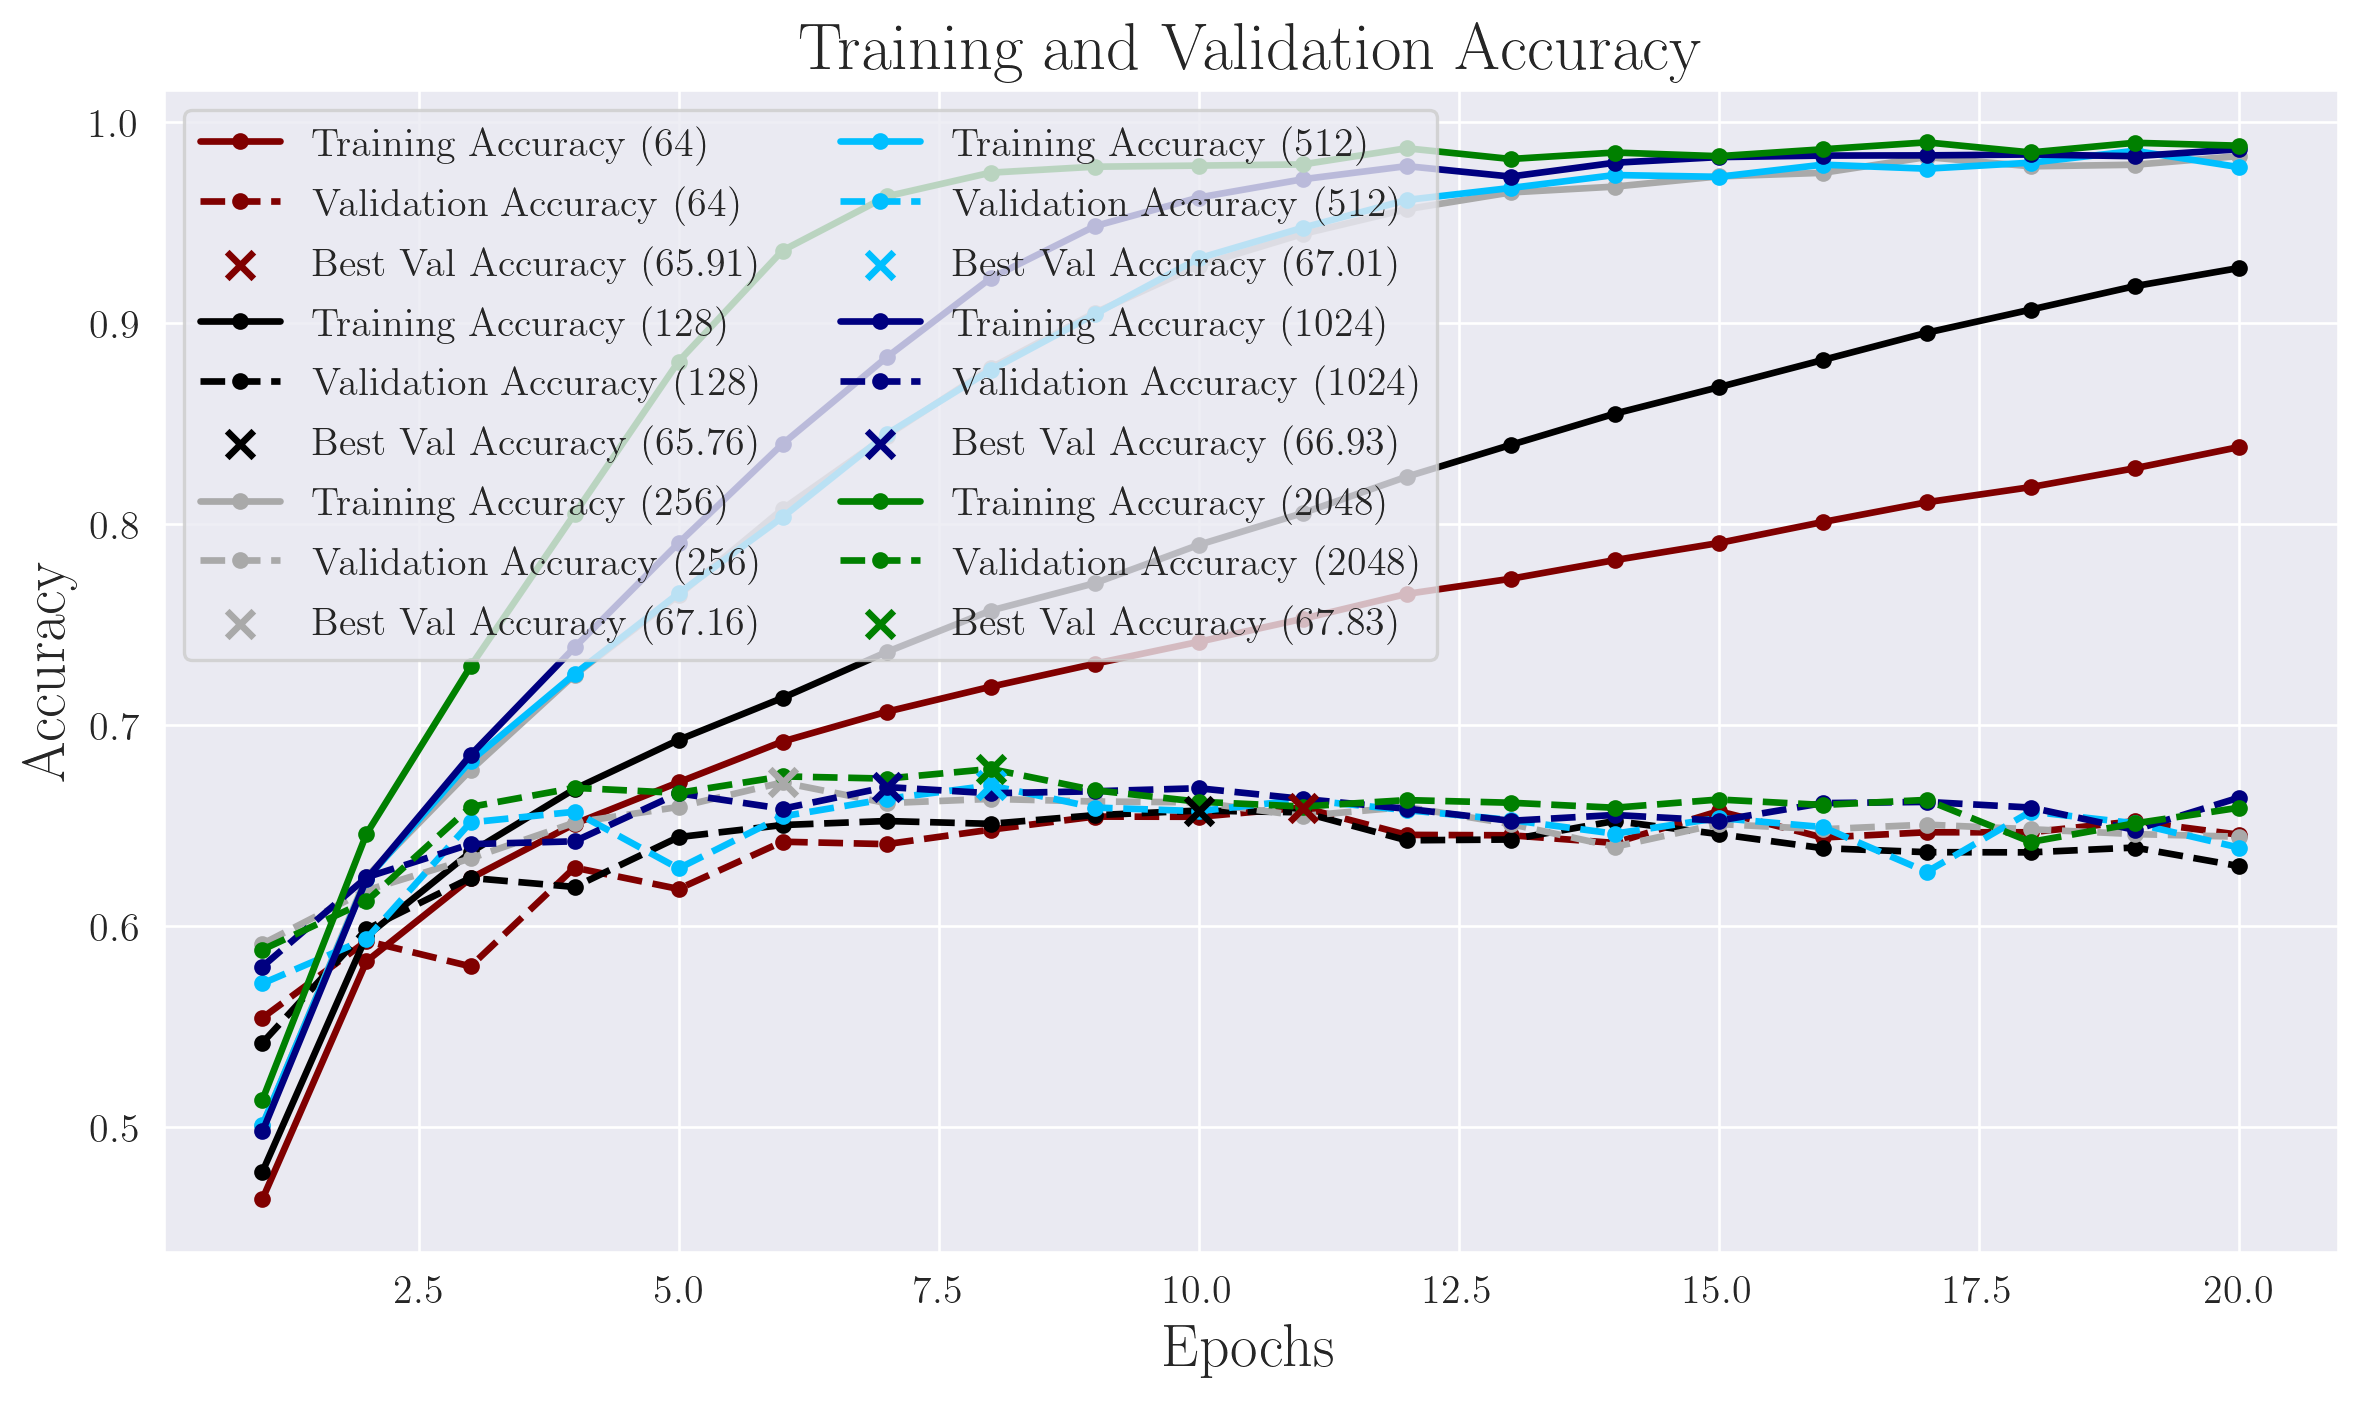

In [9]:
fig, ax = plt.subplots()
dense_sizes = [64, 128, 256, 512, 1024, 2048]
for dense_size in dense_sizes:
    # Create model
    p4_model = Sequential([
        Input(shape=(32, 32, 3)),  # input shape
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),  # convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # max pooling layer
        Flatten(),  # flatten the output
        Dense(dense_size, activation='relu'),  # dense hidden layer
        Dense(10, activation='softmax')  # output layer with softmax activation
    ])

    # Compile model
    p4_model.compile(
        optimizer='adam',  # optimizer
        loss='sparse_categorical_crossentropy',  # loss function for multi-class classification
        metrics=['acc']  # metric to track
    )

    # Train the model
    history = p4_model.fit(
        x_train, y_train,  # training data
        epochs=20,  # number of epochs
        batch_size=64,  # batch size
        validation_data=(x_test, y_test),  # validation data
        verbose=False  # suppress output during training
    )
    train_accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    epochs = np.array(history.epoch) + 1
    best_accuracy = max(val_accuracy)  # find the best validation accuracy
    best_accuracy_epoch = val_accuracy.index(best_accuracy) + 1  # find the epoch at which it occurred

    # Plot the training and validation accuracy
    line = ax.plot(epochs, train_accuracy, label=f'Training Accuracy ({dense_size})', marker='.', zorder=2)[0]
    ax.plot(epochs, val_accuracy, label=f'Validation Accuracy ({dense_size})', marker='.', ls='--', color=line.get_color(), zorder=2)
    ax.scatter(best_accuracy_epoch, best_accuracy, marker='x', color=line.get_color(), zorder=3, label=fr'Best Val Accuracy ({best_accuracy*100:.2f})')

ax.set_title('Training and Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend(ncol=2)
plt.show()

The results show that the validation accuracy increases by about 3% at 2048. There could be further increase in the accuracy, but this analysis takes a really long time. For refining in further problems, I will choose to start at 2048 and work from there.

# Problem 5
Using multiple convolution and pooling layers, and a single dense layer, find a combination of hyperparameters that minimizes your validation error. What are the optimum parameters you found? Plot the confusion matrix for this best case.

## Solution

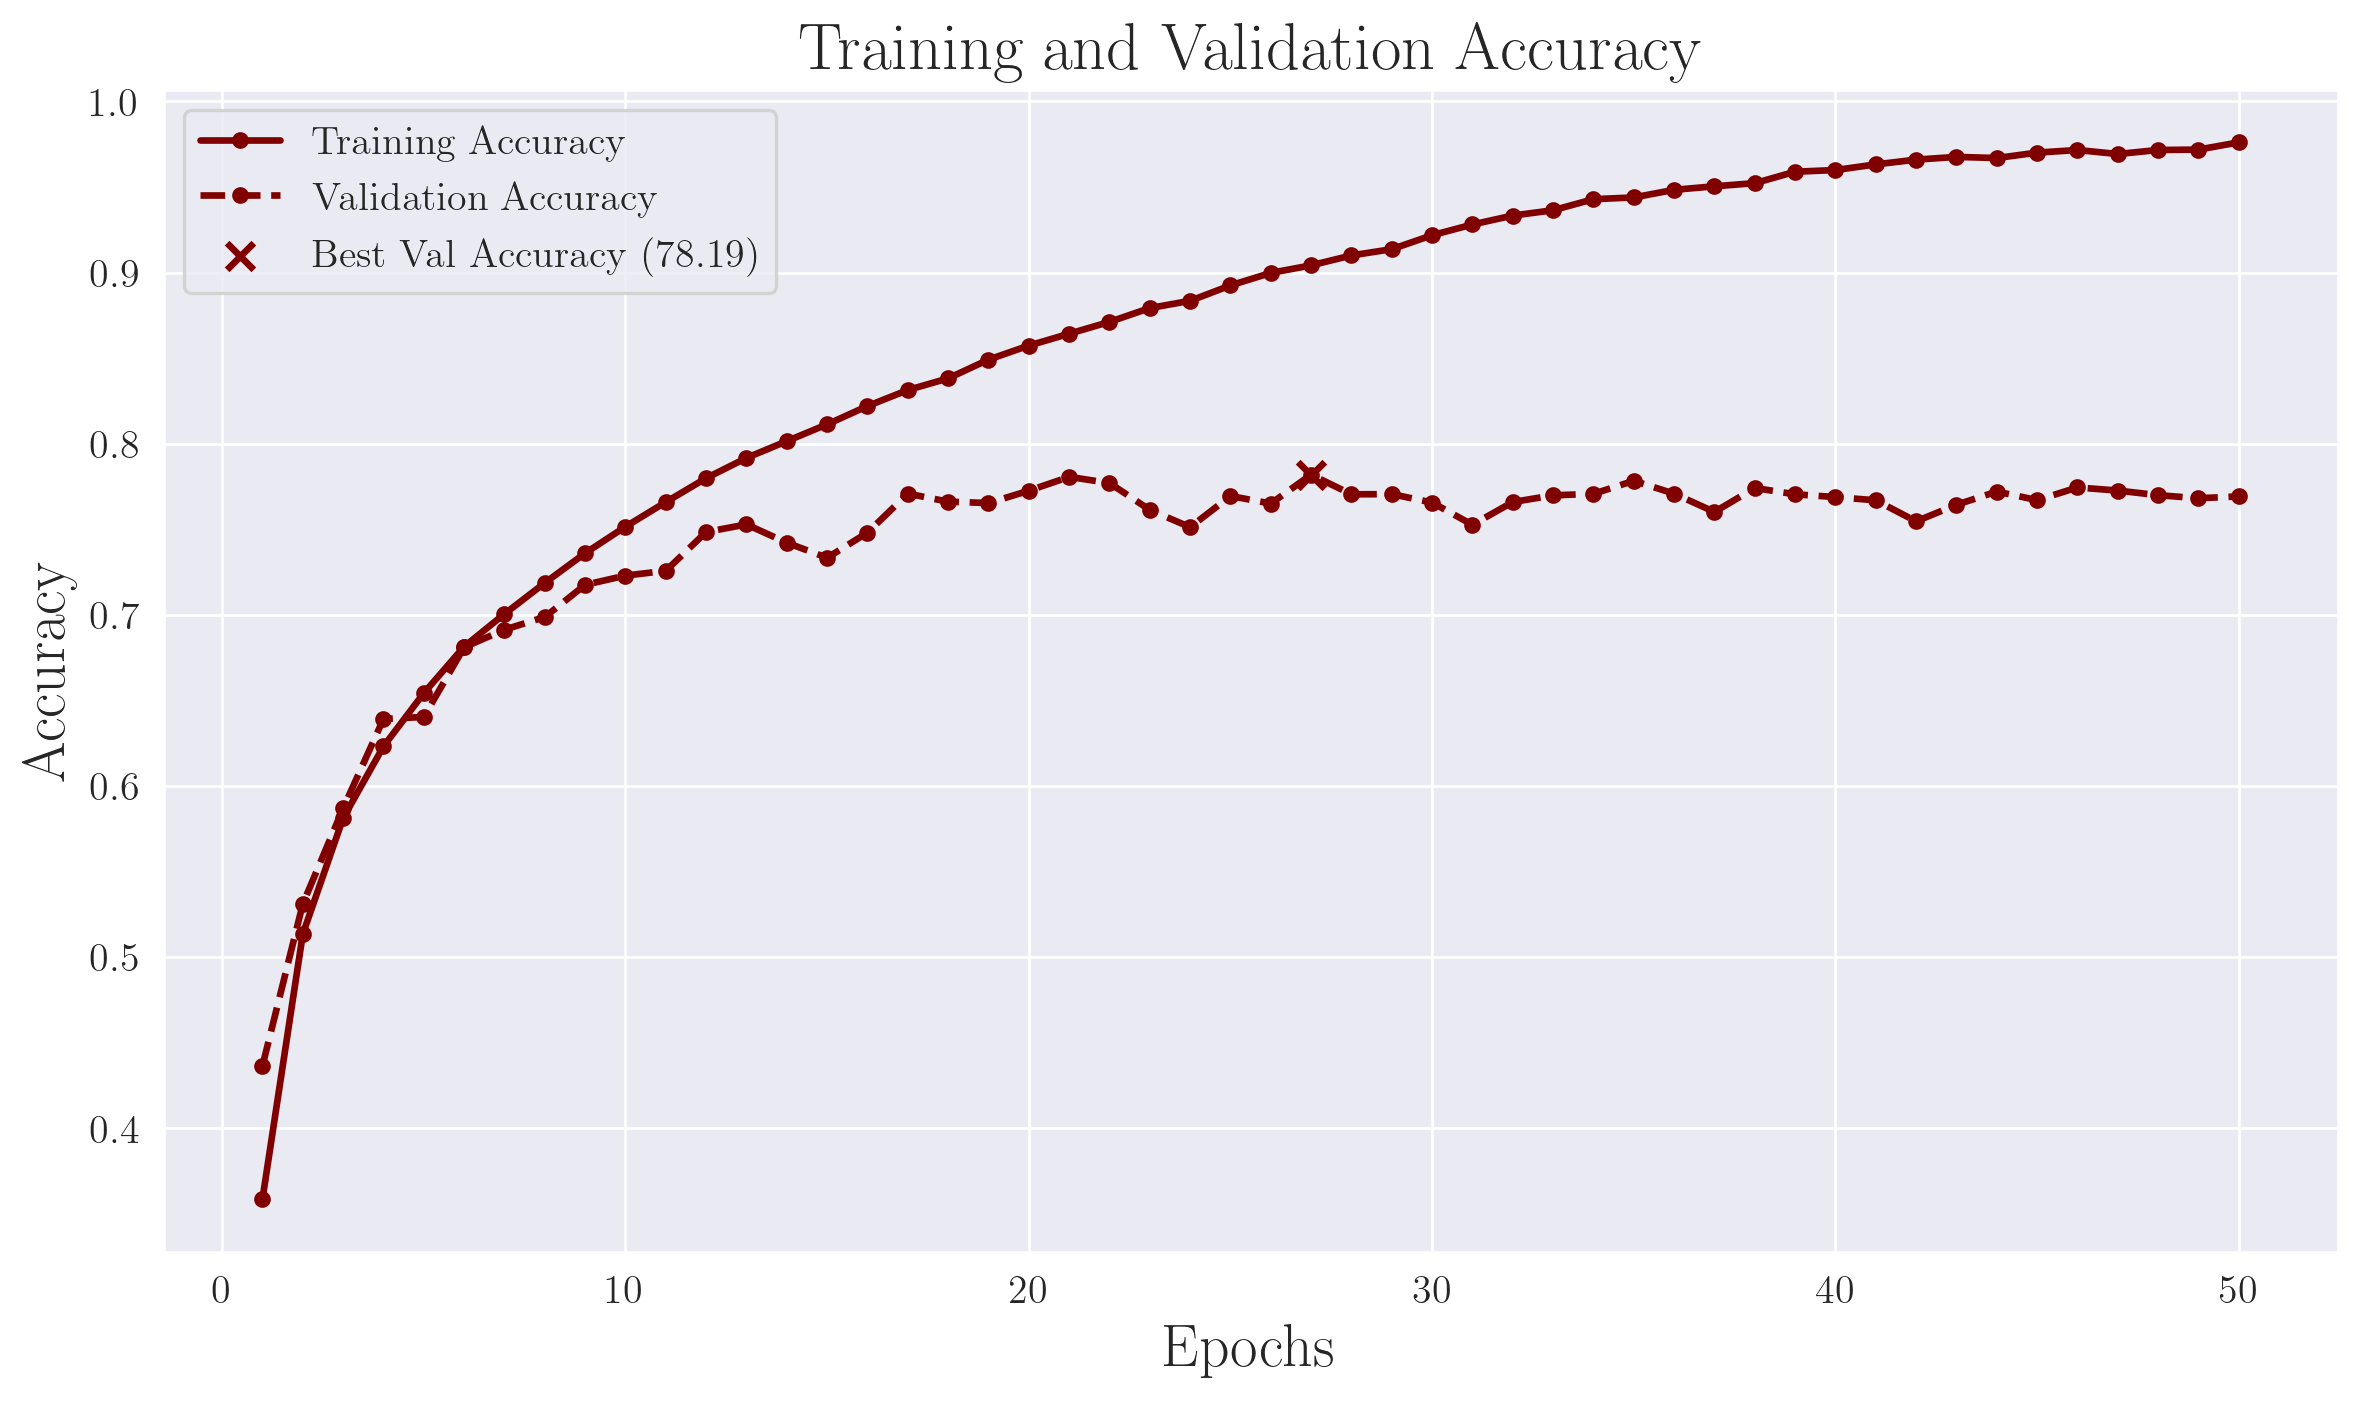

In [17]:
# Revised model with 'same' padding and fewer pooling layers to preserve dimensions
p5_model = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    GlobalAveragePooling2D(),
    Dense(2048, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile model
p5_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

# Define callbacks: save the best model and use early stopping
checkpoint_callback = ModelCheckpoint(
    'best_model_p5.keras',
    monitor='val_acc',
    save_best_only=True,
    mode='max',
    verbose=False
)
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=3,
#     restore_best_weights=True,
#     verbose=False
# )

# Train the model
history = p5_model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_test, y_test),
    # callbacks=[checkpoint_callback, early_stopping],
    callbacks=[checkpoint_callback],
    verbose=False
)
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
epochs = np.array(history.epoch) + 1
best_accuracy = max(val_accuracy)  # find the best validation accuracy
best_accuracy_epoch = val_accuracy.index(best_accuracy) + 1  # find the epoch at which it occurred

# Plot the training and validation accuracy
fig, ax = plt.subplots()
line = ax.plot(epochs, train_accuracy, label=f'Training Accuracy', marker='.', zorder=2)[0]
ax.plot(epochs, val_accuracy, label=f'Validation Accuracy', marker='.', ls='--', color=line.get_color(), zorder=2)
ax.scatter(best_accuracy_epoch, best_accuracy, marker='x', color=line.get_color(), zorder=3, label=fr'Best Val Accuracy ({best_accuracy*100:.2f})')
ax.set_title('Training and Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

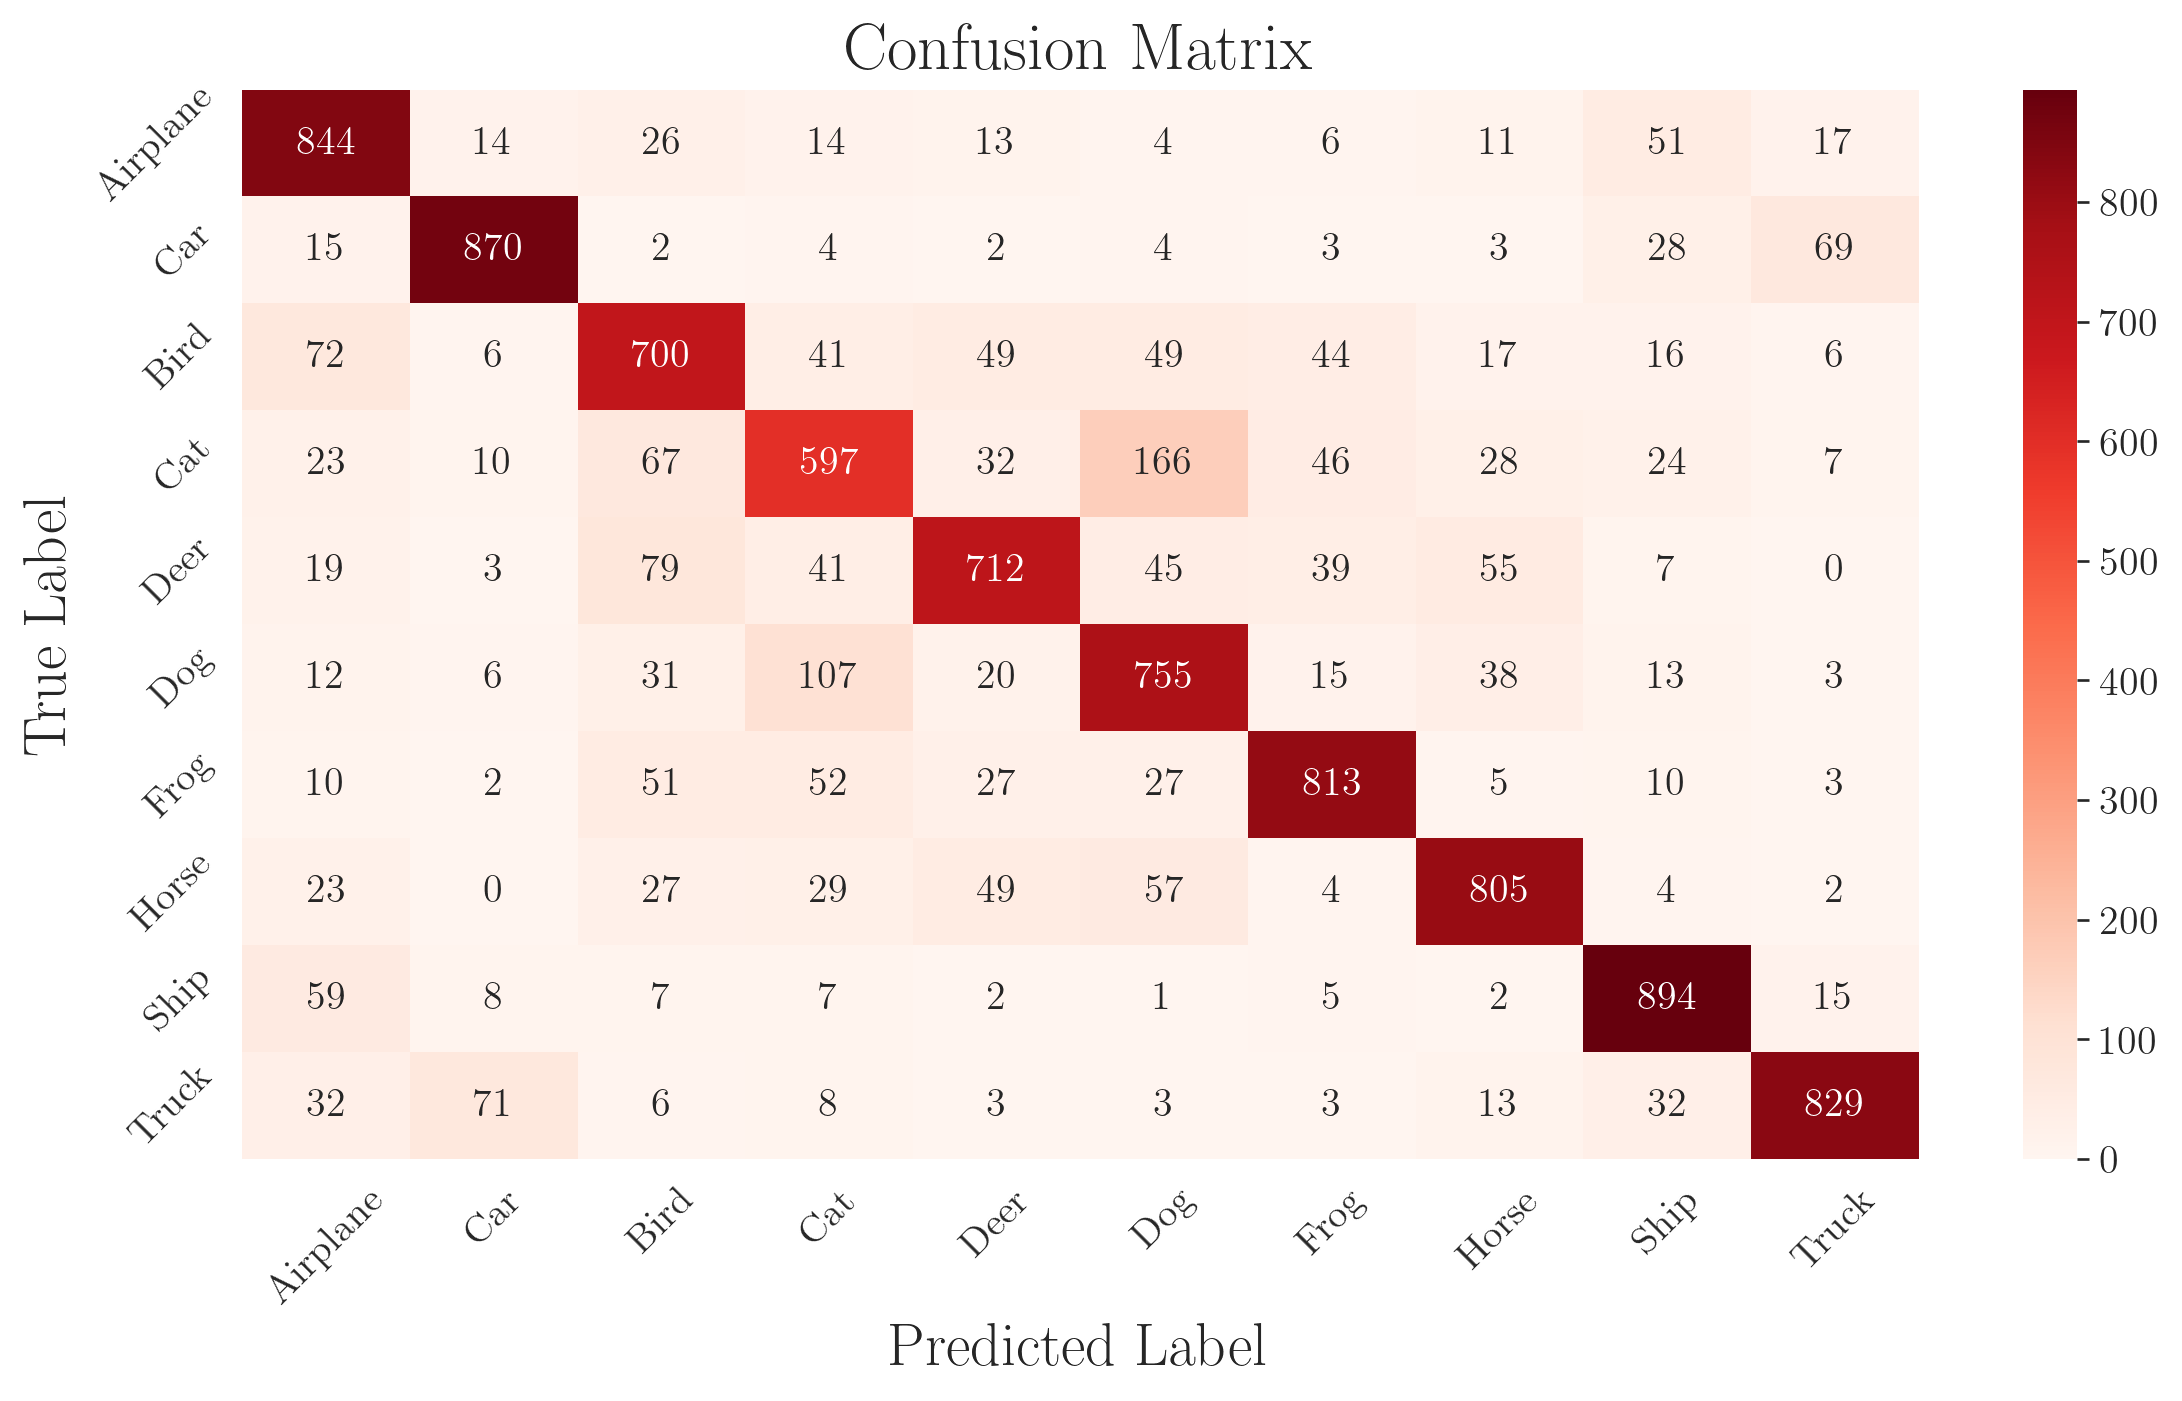

In [18]:
# Making the confusion matrix
p5_best_model = load_model('best_model_p5.keras')  # Load the best model
y_pred = p5_best_model.predict(x_test, verbose=False)  # Get predictions on the test set

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)  # finding the highest probability
cm = confusion_matrix(y_test.flatten(), y_pred_labels)

# Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=45)
plt.show()

In [19]:
# Accuracy score
accuracy = accuracy_score(y_test.flatten(), y_pred_labels)
print(f'Accuracy of the best model on the test set: {accuracy:.3%}')

Accuracy of the best model on the test set: 78.190%


In this problem, we built a more complex CNN using multiple convolutional layers with ‘same’ padding, max pooling, and a global average pooling layer, followed by a large dense layer. This architecture allowed the network to extract richer features while preventing excessive reduction in spatial dimensions. By using callbacks like model checkpointing, the model minimized validation error. I tried adding more layers and adjusting the hyperparameters and found that 32, 64, and 128 produce the best results. The final accuracy of 78% exceeds the single convolution layer by 10%, which is pretty substantial.

One method that could be used to improve these results is to add onto the training data by using the existing images and duplicating with zoom, rotations, translations, and mirroring, but this was left out on purpose due to time constraints.

# Problem 6
Now replace your convolution layers with one of the existing pretrained models available in keras and optimize your dense layer to produce the best possible fit. What is the validation accuracy in this case? How does it compare to the convolution layers you trained by hand?

## Solution
In this approach we use Keras’s pretrained MobileNetV2 as a feature extractor (with its convolutional base frozen) and then add our own dense layers on top. Note that because MobileNetV2 was originally trained on ImageNet, its preprocessing expects pixel values in a different range than our normalized CIFAR‑10 images; we therefore first rescale the images back to [0, 255] and then use the MobileNetV2 preprocessing function.

In [4]:
# Preprocess CIFAR-10 images for MobileNetV2:
# Our x_train and x_test are normalized between 0 and 1, but MobileNetV2 expects inputs in a different scale.
# First, rescale back to [0, 255], resize to 224x224, then use the MobileNetV2 preprocessing.
x_train_rescaled = (x_train*255).astype('float32')
x_test_rescaled = (x_test*255).astype('float32')

def resize_images(images, size=(224, 224)):
    resized = np.zeros((images.shape[0], size[0], size[1], images.shape[3]), dtype=np.float32)
    for im in range(images.shape[0]):
        resized[im] = cv2.resize(images[im], size)
    return resized

x_train_resized = resize_images(x_train_rescaled)
x_test_resized = resize_images(x_test_rescaled)

x_train_preprocessed = preprocess_input(x_train_resized)
x_test_preprocessed = preprocess_input(x_test_resized)

In [ ]:
# Load the pretrained MobileNetV2 model without its top, and freeze its layers.
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

# Build our new model by stacking our dense layers on top of the frozen base.
p6_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),  # optimized dense layer
    Dense(10, activation='softmax')
])

# Compile the model.
p6_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

# Create callback
checkpoint_callback = ModelCheckpoint(
    'best_model_p6.keras',
    monitor='val_acc',
    save_best_only=True,
    mode='max',
    verbose=True
)

# Train the model.
history_p6 = p6_model.fit(
    x_train_preprocessed, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test_preprocessed, y_test),
    callbacks=[checkpoint_callback],
    verbose=True
)

# Get accuracy results
train_accuracy = history_p6.history['acc']
val_accuracy = history_p6.history['val_acc']
epochs = np.array(history_p6.epoch) + 1
best_accuracy = max(val_accuracy)
best_accuracy_epoch = val_accuracy.index(best_accuracy) + 1

# Plot the training and validation accuracy
fig, ax = plt.subplots()
line = ax.plot(epochs, train_accuracy, label=f'Training Accuracy', marker='.', zorder=2)[0]
ax.plot(epochs, val_accuracy, label=f'Validation Accuracy', marker='.', ls='--', color=line.get_color(), zorder=2)
ax.scatter(best_accuracy_epoch, best_accuracy, marker='x', color=line.get_color(), zorder=3, label=fr'Best Val Accuracy ({best_accuracy*100:.2f})')
ax.set_title('Training and Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

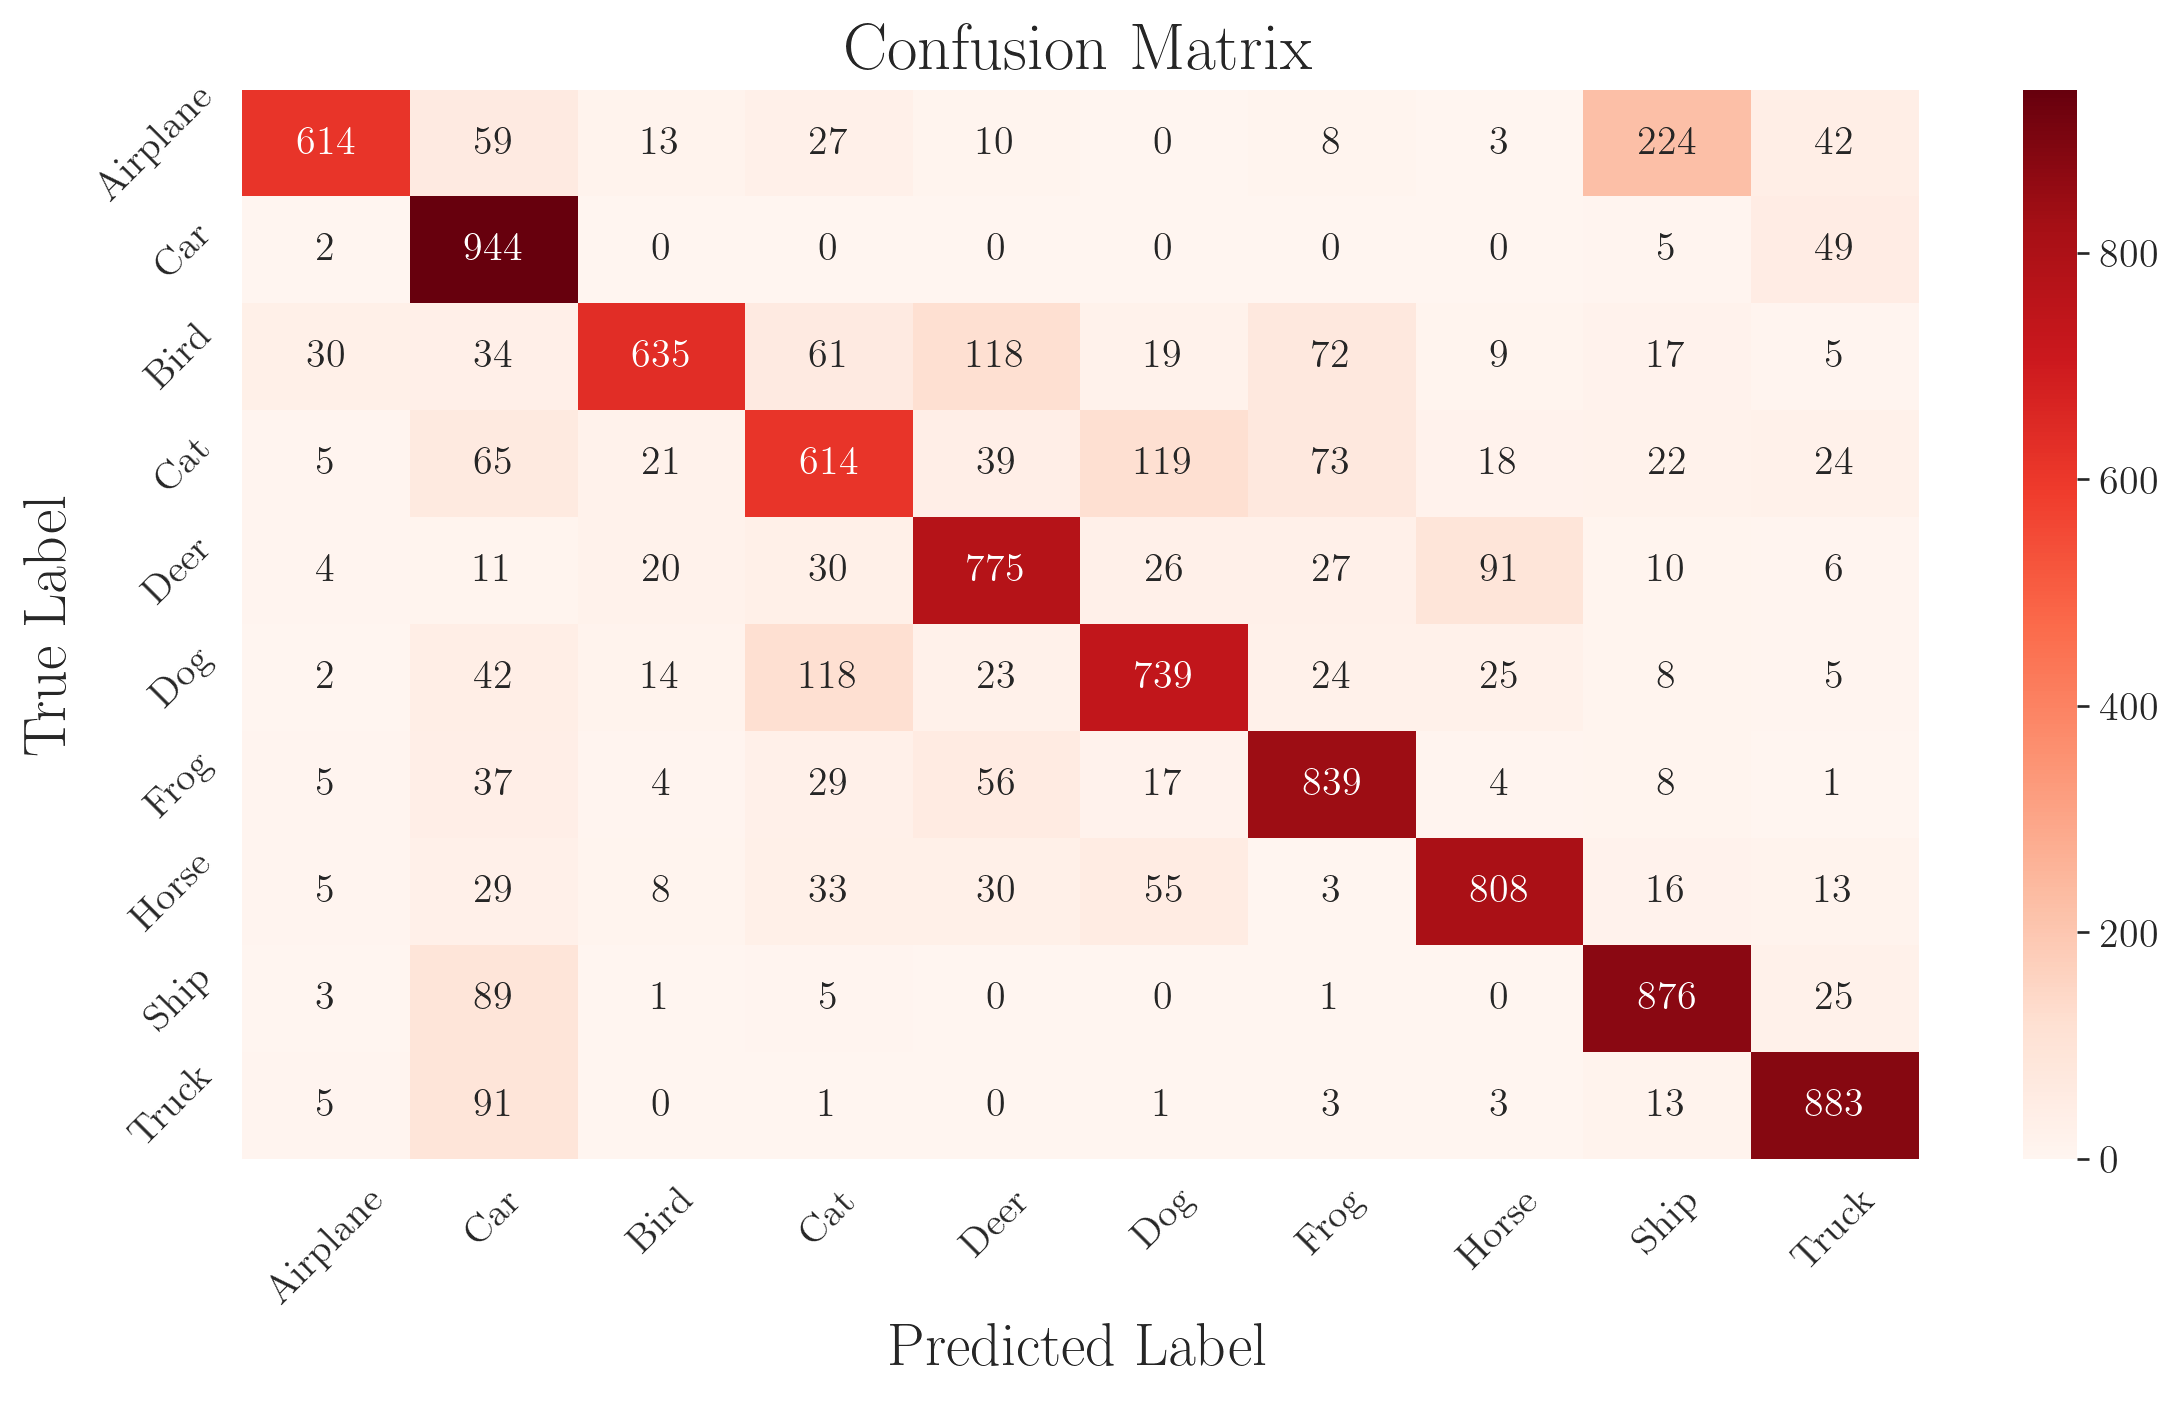

In [8]:
# Making the confusion matrix
p6_best_model = load_model('best_model_p6.keras')  # Load the best model
y_pred = p6_best_model.predict(x_test_preprocessed, verbose=False)  # Get predictions on the test set

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)  # finding the highest probability
cm = confusion_matrix(y_test.flatten(), y_pred_labels)

# Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=45)
plt.show()

In [9]:
# Accuracy score
accuracy = accuracy_score(y_test.flatten(), y_pred_labels)
print(f'Accuracy of the best model on the test set: {accuracy:.3%}')

Accuracy of the best model on the test set: 77.270%
